### Setup Environment:

In [14]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [15]:
# Constants:
DATASET = '/opc/davidres/retina/mbrset/data'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'mBRSET/')
LABEL = 'insurance'
TEST_SIZE = 0.2
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'file'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = None
NORM_STD =  None

BACKBONE = 'convnextv2_large'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 16
NUM_WORKERS = 4

LOSS = None
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [16]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df = df[df['file'] != '985.1.jpg'] # this is missing
df.head()

loading csv file in /home/chenweiw/retina/mbrset/data/labels.csv


,patient,age,sex,dm_time,insulin,insulin_time,oraltreatment_dm,systemic_hypertension,insurance,educational_level,...,nephropathy,neuropathy,diabetic_foot,file,laterality,final_artifacts,final_quality,final_icdr,final_edema,normality
0,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.1.jpg,right,yes,yes,4.0,no,abnormal
1,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.2.jpg,right,yes,yes,4.0,no,abnormal
2,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.3.jpg,left,yes,yes,4.0,no,abnormal
3,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.4.jpg,left,yes,yes,4.0,no,abnormal
4,10,63,0,7.0,0.0,NaN,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,10.1.jpg,right,yes,yes,0.0,no,abnormal


In [17]:
df.insurance.value_counts()

0.0    4719
1.0     396
Name: insurance, dtype: int64

In [18]:

df[LABEL] = df[LABEL].apply(lambda x: '0' if x == 0 else '1')

Train data shape: (4130, 25)
Test data shape: (1033, 25)


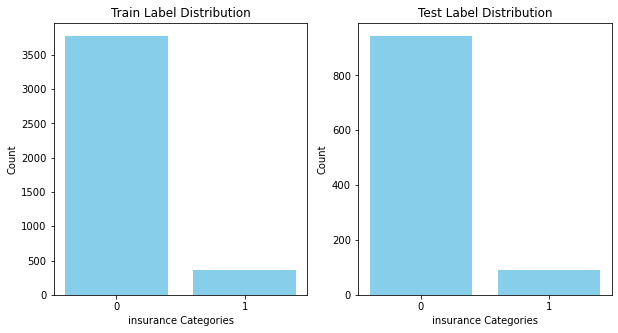

Getting validation set...


In [19]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
# df_test, df_val = split_data(df_test, LABEL, 0.20)
df_val=df_test

### Dataloaders

In [20]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [21]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((SHAPE)),
    # transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(25),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [22]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

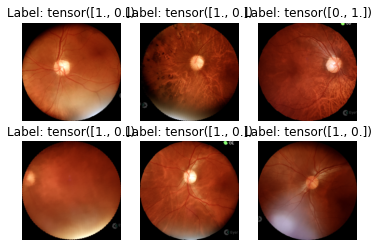

In [23]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [24]:
# Create the model
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

### Training:

In [25]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [26]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone=f'{BACKBONE}_{num_classes}class_{LABEL}')

100%|██████████| 65/65 [00:13<00:00,  4.96it/s]


Epoch 1, Train Loss: 0.6990842753625744, Val Loss: 0.6728239880158351, F1 Score: 0.47749114820435, acc0.9138431752178122
cm[[944   0]
 [ 89   0]]


100%|██████████| 65/65 [00:12<00:00,  5.12it/s]


Epoch 2, Train Loss: 0.6692398849831585, Val Loss: 0.6767347363325266, F1 Score: 0.47749114820435, acc0.9138431752178122
cm[[944   0]
 [ 89   0]]


100%|██████████| 65/65 [00:12<00:00,  5.17it/s]


Epoch 3, Train Loss: 0.6541208191037639, Val Loss: 0.6719347646603218, F1 Score: 0.5110063675027122, acc0.7512100677637947
cm[[750 194]
 [ 63  26]]


100%|██████████| 65/65 [00:13<00:00,  4.91it/s]


Epoch 4, Train Loss: 0.6630784774263854, Val Loss: 0.6778338629465837, F1 Score: 0.5090015754759807, acc0.9138431752178122
cm[[941   3]
 [ 86   3]]


100%|██████████| 65/65 [00:13<00:00,  5.00it/s]


Epoch 5, Train Loss: 0.5902819619675861, Val Loss: 0.6790456799360421, F1 Score: 0.594175557880734, acc0.9022265246853823
cm[[916  28]
 [ 73  16]]


100%|██████████| 65/65 [00:13<00:00,  4.91it/s]


Epoch 6, Train Loss: 0.5292602140585888, Val Loss: 0.6307930432833158, F1 Score: 0.5036646304722725, acc0.6418199419167473
cm[[604 340]
 [ 30  59]]


100%|██████████| 65/65 [00:13<00:00,  4.96it/s]


Epoch 7, Train Loss: 0.39144618138958587, Val Loss: 0.9120572626017607, F1 Score: 0.5657442608568504, acc0.9109390125847048
cm[[931  13]
 [ 79  10]]


100%|██████████| 65/65 [00:13<00:00,  4.89it/s]


Epoch 8, Train Loss: 0.30625302261137133, Val Loss: 0.6179930352247678, F1 Score: 0.6309156462143113, acc0.8402710551790901
cm[[823 121]
 [ 44  45]]


100%|██████████| 65/65 [00:12<00:00,  5.14it/s]


Epoch 9, Train Loss: 0.205911393683677, Val Loss: 0.7940865559646717, F1 Score: 0.6482993016019635, acc0.888673765730881
cm[[886  58]
 [ 57  32]]


100%|██████████| 65/65 [00:13<00:00,  4.93it/s]


Epoch 10, Train Loss: 0.18278164758695772, Val Loss: 0.9142618260131432, F1 Score: 0.6354674766583227, acc0.8964181994191674
cm[[900  44]
 [ 63  26]]


100%|██████████| 65/65 [00:13<00:00,  4.91it/s]


Epoch 11, Train Loss: 0.14135022988025114, Val Loss: 0.9981898108353982, F1 Score: 0.6069752694990489, acc0.8838334946757018
cm[[890  54]
 [ 66  23]]


100%|██████████| 65/65 [00:12<00:00,  5.17it/s]


Epoch 12, Train Loss: 0.08063865354658611, Val Loss: 0.8922167767698949, F1 Score: 0.6501524021481446, acc0.8848015488867377
cm[[880  64]
 [ 55  34]]


100%|██████████| 65/65 [00:13<00:00,  4.92it/s]


Epoch 13, Train Loss: 0.06824116805041547, Val Loss: 0.9030797329516365, F1 Score: 0.6442726105876092, acc0.882865440464666
cm[[879  65]
 [ 56  33]]


100%|██████████| 65/65 [00:13<00:00,  4.84it/s]


Epoch 14, Train Loss: 0.06672629779928389, Val Loss: 1.0454090354641756, F1 Score: 0.6447018570193777, acc0.888673765730881
cm[[887  57]
 [ 58  31]]


100%|██████████| 65/65 [00:12<00:00,  5.02it/s]


Epoch 15, Train Loss: 0.05867090211186961, Val Loss: 1.2913513334217266, F1 Score: 0.6423923232810427, acc0.9138431752178122
cm[[922  22]
 [ 67  22]]


100%|██████████| 65/65 [00:13<00:00,  4.89it/s]


Epoch 16, Train Loss: 0.047351061531738556, Val Loss: 1.1986969155438532, F1 Score: 0.6156102053974395, acc0.9022265246853823
cm[[912  32]
 [ 69  20]]


100%|██████████| 65/65 [00:12<00:00,  5.03it/s]


Epoch 17, Train Loss: 0.05254644995018602, Val Loss: 0.784931087665833, F1 Score: 0.6510912605730466, acc0.8635043562439496
cm[[849  95]
 [ 46  43]]


100%|██████████| 65/65 [00:12<00:00,  5.11it/s]


Epoch 18, Train Loss: 0.021930824979172453, Val Loss: 1.012161721740491, F1 Score: 0.6579826129731059, acc0.8983543078412392
cm[[897  47]
 [ 58  31]]


100%|██████████| 65/65 [00:12<00:00,  5.02it/s]


Epoch 19, Train Loss: 0.03196549729331042, Val Loss: 1.1706189540143197, F1 Score: 0.6360659335581943, acc0.8818973862536302
cm[[880  64]
 [ 58  31]]


100%|██████████| 65/65 [00:13<00:00,  4.90it/s]


Epoch 20, Train Loss: 0.033081798650626396, Val Loss: 0.7926555299701599, F1 Score: 0.6846186725285461, acc0.8838334946757018
cm[[867  77]
 [ 43  46]]


100%|██████████| 65/65 [00:12<00:00,  5.18it/s]


Epoch 21, Train Loss: 0.018225228268476508, Val Loss: 1.5000343272238612, F1 Score: 0.6711011373880353, acc0.9196515004840271
cm[[924  20]
 [ 63  26]]


100%|██████████| 65/65 [00:13<00:00,  4.98it/s]


Epoch 22, Train Loss: 0.018440943404593464, Val Loss: 1.151137127669958, F1 Score: 0.6449213676515031, acc0.8557599225556631
cm[[840 104]
 [ 45  44]]


100%|██████████| 65/65 [00:13<00:00,  5.00it/s]


Epoch 23, Train Loss: 0.016932339464278547, Val Loss: 1.4082815149807943, F1 Score: 0.6904537671232877, acc0.9186834462729913
cm[[918  26]
 [ 58  31]]


100%|██████████| 65/65 [00:13<00:00,  4.88it/s]


Epoch 24, Train Loss: 0.023563892235550745, Val Loss: 1.5184297843106414, F1 Score: 0.6656702631741633, acc0.9138431752178122
cm[[917  27]
 [ 62  27]]


100%|██████████| 65/65 [00:13<00:00,  4.95it/s]


Epoch 25, Train Loss: 0.015166993513687615, Val Loss: 1.5427921531014503, F1 Score: 0.6491966964601429, acc0.9060987415295256
cm[[910  34]
 [ 63  26]]


100%|██████████| 65/65 [00:13<00:00,  4.87it/s]


Epoch 26, Train Loss: 0.041347806759133805, Val Loss: 1.501755251739031, F1 Score: 0.6628690105325619, acc0.914811229428848
cm[[919  25]
 [ 63  26]]


100%|██████████| 65/65 [00:13<00:00,  4.94it/s]


Epoch 27, Train Loss: 0.012220122528199059, Val Loss: 1.5025650556770136, F1 Score: 0.6899578343240316, acc0.920619554695063
cm[[921  23]
 [ 59  30]]


100%|██████████| 65/65 [00:13<00:00,  4.96it/s]


Epoch 28, Train Loss: 0.003336214310854011, Val Loss: 1.1427192060724618, F1 Score: 0.7140347270758816, acc0.9022265246853823
cm[[885  59]
 [ 42  47]]


100%|██████████| 65/65 [00:12<00:00,  5.18it/s]


Epoch 29, Train Loss: 0.024712363480363354, Val Loss: 1.163086384556328, F1 Score: 0.6457610973518766, acc0.8867376573088093
cm[[884  60]
 [ 57  32]]


100%|██████████| 65/65 [00:12<00:00,  5.13it/s]


Epoch 30, Train Loss: 0.043752378800919395, Val Loss: 1.1871815885811186, F1 Score: 0.6718627269786999, acc0.89351403678606
cm[[886  58]
 [ 52  37]]


100%|██████████| 65/65 [00:12<00:00,  5.10it/s]


Epoch 31, Train Loss: 0.04199899997726005, Val Loss: 1.4074742529057682, F1 Score: 0.6573388530637158, acc0.9031945788964182
cm[[904  40]
 [ 60  29]]


100%|██████████| 65/65 [00:12<00:00,  5.11it/s]


Epoch 32, Train Loss: 0.04389808141675523, Val Loss: 1.527592646004632, F1 Score: 0.6668601651186791, acc0.9225556631171346
cm[[929  15]
 [ 65  24]]


100%|██████████| 65/65 [00:12<00:00,  5.12it/s]


Epoch 33, Train Loss: 0.017848259062291857, Val Loss: 1.645358278129984, F1 Score: 0.6825729611146334, acc0.9235237173281704
cm[[927  17]
 [ 62  27]]


100%|██████████| 65/65 [00:13<00:00,  4.90it/s]


Epoch 34, Train Loss: 0.01642502104807002, Val Loss: 2.152825577437985, F1 Score: 0.5994428721057206, acc0.9157792836398838
cm[[932  12]
 [ 75  14]]


100%|██████████| 65/65 [00:13<00:00,  4.86it/s]


Epoch 35, Train Loss: 0.03677968565551539, Val Loss: 1.760497867163772, F1 Score: 0.6880642085187539, acc0.9264278799612778
cm[[930  14]
 [ 62  27]]
Early stopping triggered.


### Test

100%|██████████| 65/65 [00:13<00:00,  4.74it/s]


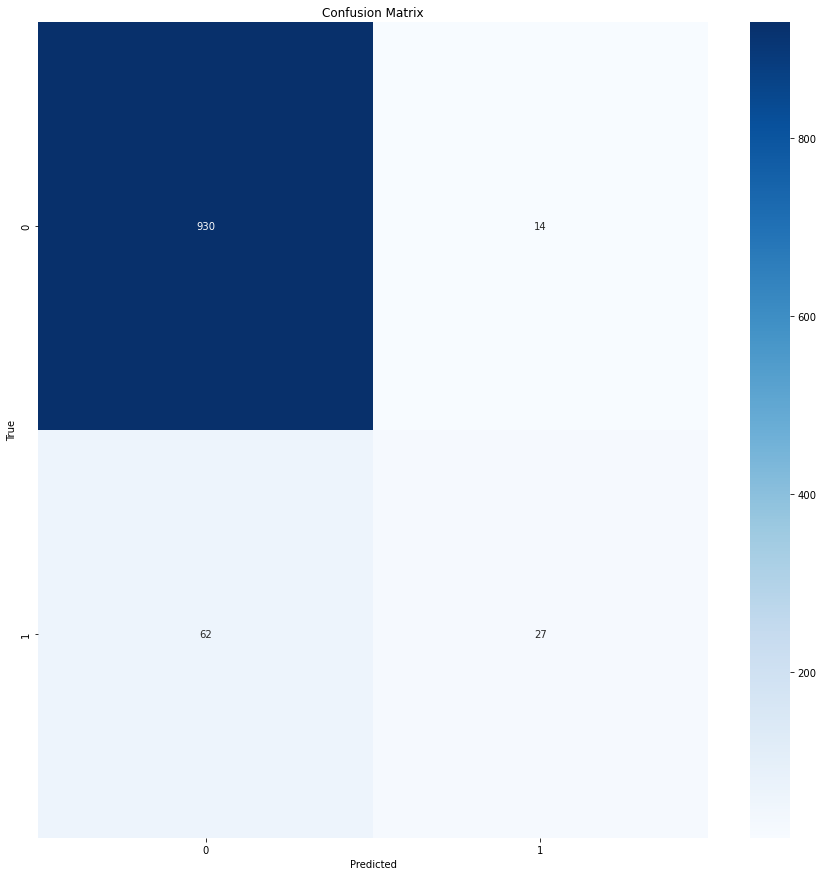

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       944
           1       0.66      0.30      0.42        89

    accuracy                           0.93      1033
   macro avg       0.80      0.64      0.69      1033
weighted avg       0.91      0.93      0.91      1033

##################################################  Saliency Maps  ##################################################

Class 0:


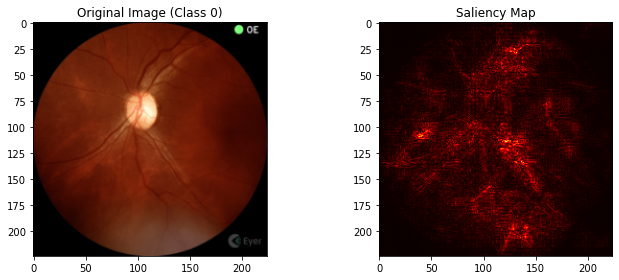

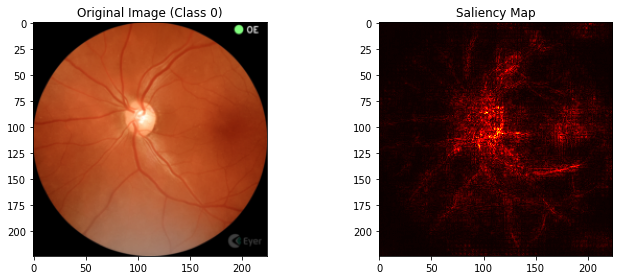

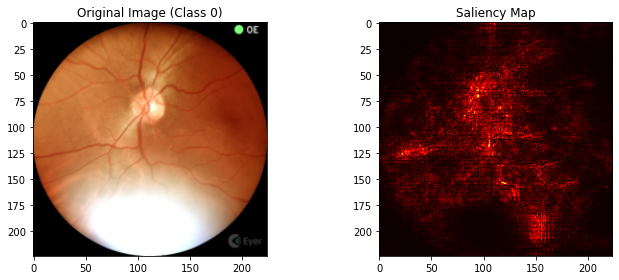

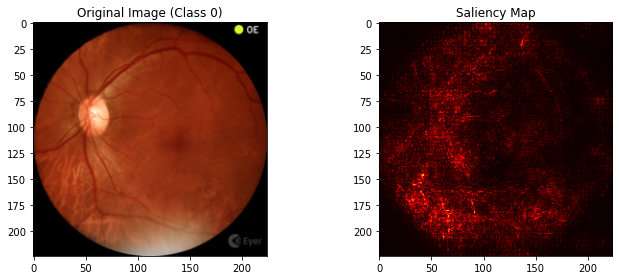

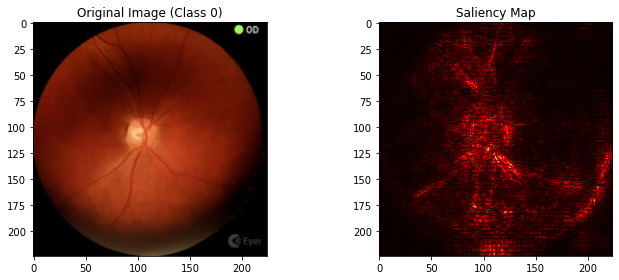

Class 1:


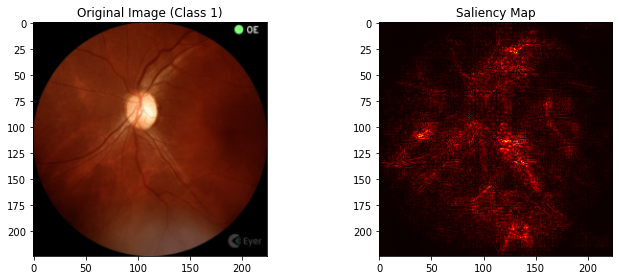

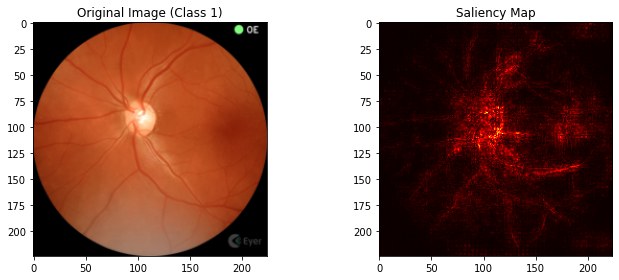

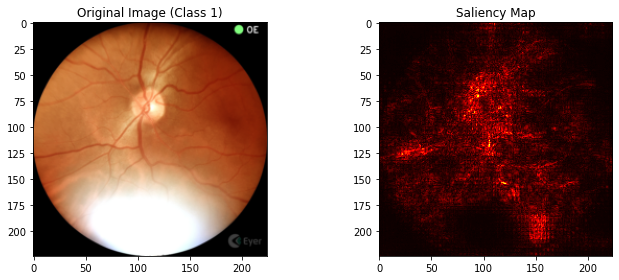

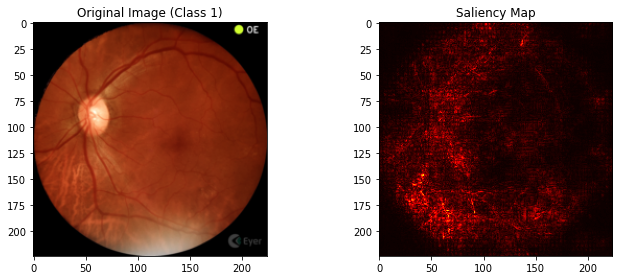

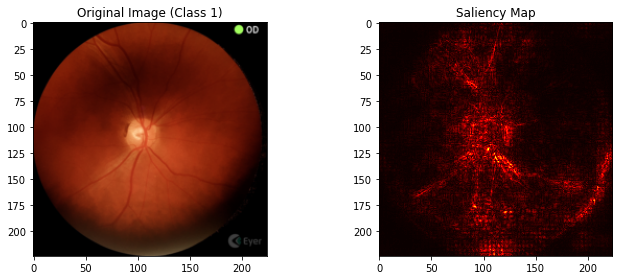

In [27]:
test(model, test_dataloader, saliency=True, device=device)

In [ ]:
# Good quality images
adequate_df = df_test[df_test['final_quality'] == 'yes']

# Bad quality images
inadequate_df = df_test[df_test['final_quality'] == 'no']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

In [ ]:
test(model, adequate_dataloader, saliency=True, device=device, save=True)

#### Inadequate image quality

In [ ]:
test(model, inadequate_dataloader, saliency=True, device=device)